<a href="https://colab.research.google.com/github/Stan-Leigh/amazon-customers-sentiment-analysis/blob/main/Predicting_Sentiments_of_Amazon_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We connect our google drive to the colab notebook because the dataset is in my google drive. Get the dataset [here](https://drive.google.com/drive/folders/1EHYENl99dH4iJS0dtvgh_hJVA-0AdVzJ?usp=sharing)

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer # responsible for creating the bag of words.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier # classifier that ignores input features and just predicts output
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler # for handling imbalance in data. Must have Tensorflow installed for it to work.
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('/content/drive/My Drive/1.Amazon Use-case/Reviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Pre-processsing

In [5]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
# Create new column using other columns
df['Helpful%'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful%
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0


In [9]:
df['Helpful%'].nunique()

952

In [10]:
df['%upvote'] = pd.cut(df['Helpful%'], bins=[-1.1, 0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])

In [11]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful%,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


## Data Exploration

In [12]:
df1 = df.groupby(['Score', '%upvote']).agg({'Id': 'count'}).reset_index()

In [13]:
df1

,Score,%upvote,Id
0,1,Empty,20326
1,1,0-20%,2338
2,1,20-40%,4649
3,1,40-60%,6586
4,1,60-80%,5838
5,1,80-100%,12531
6,2,Empty,14838
7,2,0-20%,762
8,2,20-40%,1618
9,2,40-60%,3051


In [14]:
pivot = df1.pivot(index='%upvote', columns='Score')

In [15]:
pivot

Id                             
Score        1      2      3      4       5
%upvote                                    
Empty    20326  14838  23485  46796  198381
0-20%     2338    762    474    116     432
20-40%    4649   1618   1506    909    2275
40-60%    6586   3051   3384   3185   10312
60-80%    5838   2486   2754   2941   11060
80-100%  12531   7014  11037  26707  140661

<AxesSubplot:xlabel='None-Score', ylabel='%upvote'>

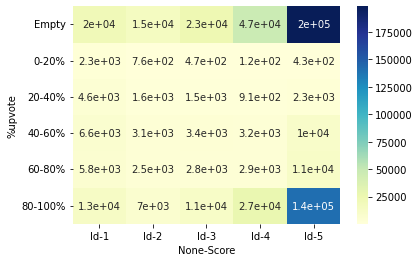

In [16]:
sns.heatmap(pivot, annot=True, cmap='YlGnBu')

The data shows that reviews by customers are more positive because many of the customers gave a score of 5, even those that had a helpful percentage of <= 0

In [17]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

We remove rows with a score of 3 because we don't want to predict for customers that are neutral, i.e. 3 is the mid-score for a range of 1 to 5.

In [18]:
df2 = df[df['Score'] != 3]

Next, we create the X and y variables to store the independent and dependent variables

In [19]:
X = df2['Text']

In [20]:
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df2['Score'].map(y_dict)

In [21]:
c = CountVectorizer(stop_words='english')

In [22]:
X_c = c.fit_transform(X)

In [23]:
X_c.shape

(525814, 114969)

525,814 rows in the dataset, 114,969 columns of the different words in all the rows of data. The table contains the frequency of each word in each column for each row of data.

## Train a model and test accuracy

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=2023)

In [25]:
X_train.shape

(394360, 114969)

In [26]:
logreg = LogisticRegression()

In [27]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
logreg.score(X_test, y_test)

0.9358558887519589

### Get Top 20 positive words and Top 20 negative words

In [29]:
w = c.get_feature_names_out()
w

array(['00', '000', '0000', ..., 'être', 'île', 'ît'], dtype=object)

In [30]:
coef = logreg.coef_.tolist()[0]
print(len(coef))
print('\n')
coef[:10]

114969




[-0.39581345428198633,
 -0.1468733304367674,
 0.3251984670940823,
 -0.006843151827600969,
 -0.014100121946515956,
 -0.010356418289297448,
 0.00024078397329976706,
 -0.005512125888885897,
 0.00026611544480171796,
 0.0002768660002854857]

In [31]:
coef_df = pd.DataFrame({'Word': w, 'Coefficient': coef})
coef_df

,Word,Coefficient
0,00,-0.395813
1,000,-0.146873
2,0000,0.325198
3,000001,-0.006843
4,00001,-0.014100
...,...,...
114964,çaykur,0.000720
114965,çelem,-0.118679
114966,être,0.020099
114967,île,0.009611


In [32]:
# sort dataframe by coefficient then by word
coef_df = coef_df.sort_values(['Coefficient', 'Word'], ascending=False)

For the top 20 positive words

In [33]:
coef_df.head(20)

,Word,Coefficient
80600,pleasantly,4.129458
39072,downside,3.199159
5865,addicting,2.933891
94667,skeptical,2.933329
55029,hooked,2.520559
113138,worries,2.516235
39214,drawback,2.396756
102857,terrific,2.255749
40342,economical,2.240080
102067,tastiest,2.218760


For top 20 negative words

In [34]:
coef_df.tail(20)

,Word,Coefficient
94747,skip,-2.285777
89864,ruined,-2.303368
24945,canceled,-2.371709
56229,ick,-2.373578
110404,vomited,-2.403750
37563,disappointment,-2.502738
23814,bummer,-2.543169
46083,flavorless,-2.614900
41118,embarrassed,-2.711448
37528,disapointed,-2.736592


Next, we write a function to automate everything we just did.

In [35]:
def text_fit(X, y, nlp_model, ml_model, coef_show=1):
  X_c = nlp_model.fit_transform(X)
  print(f'Features: {X_c.shape[1]}')

  X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=2023)

  ml_model.fit(X_train, y_train)
  acc = ml_model.score(X_test, y_test)
  print(acc)

  if coef_show==1:
    w = nlp_model.get_feature_names_out()
    coef = ml_model.coef_.tolist()[0]
    coef_df = pd.DataFrame({'Word': w, 'Coefficient': coef})
    coef_df = coef_df.sort_values(['Coefficient', 'Word'], ascending=False)

    print('\n')
    print('Top 20 Positive words')
    print(coef_df.head(20))

    print('\n')
    print('Top 20 Negative words')
    print(coef_df.tail(20))

In [36]:
c = CountVectorizer(stop_words='english')

In [37]:
logreg = LogisticRegression()

In [38]:
text_fit(X, y, c, logreg)

Features: 114969


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9358558887519589


Top 20 Positive words
              Word  Coefficient
80600   pleasantly     4.129458
39072     downside     3.199159
5865     addicting     2.933891
94667    skeptical     2.933329
55029       hooked     2.520559
113138     worries     2.516235
39214     drawback     2.396756
102857    terrific     2.255749
40342   economical     2.240080
102067    tastiest     2.218760
68460          met     2.152069
113137     worried     2.136871
111520     welcome     2.126217
87967       resist     2.112798
54130     hesitant     2.112553
78641        penny     2.095617
74359     obsessed     2.080351
23089       brings     2.064727
78889      perfect     2.043317
35726       delish     2.040302


Top 20 Negative words
                  Word  Coefficient
94747             skip    -2.285777
89864           ruined    -2.303368
24945         canceled    -2.371709
56229              ick    -2.373578
110404         vomited    -2.403750
37563   disappointment    -2.502738
23814    

Let's create another function to easily make predictions using a machine learning model

In [39]:
def predict(X, y, nlp_model, ml_model):
  X_c = nlp_model.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=2023)
  ml_model.fit(X_train, y_train)
  pred = ml_model.predict(X_test)

  cm = confusion_matrix(pred, y_test)
  print(cm)
  print('\n')

  acc = accuracy_score(pred, y_test)
  print(acc)

In [40]:
c = CountVectorizer(stop_words='english')
logreg = LogisticRegression()

In [41]:
predict(X, y, c, logreg)

[[ 14960   2815]
 [  5617 108062]]


0.9358558887519589


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Applying more NLP techniques on the Data

In [42]:
# using dummy classfier on the function
text_fit(X, y, c, DummyClassifier(), 0)

Features: 114969
0.8434661554612259


In [43]:
tfidf = TfidfVectorizer(stop_words='english')

In [44]:
text_fit(X, y, tfidf, logreg, 0)

Features: 114969
0.9339997261399425


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
predict(X, y, tfidf, logreg)

[[ 14255   2354]
 [  6322 108523]]


0.9339997261399425


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Data Preparation for predicting the upvotes

We'll focus on customers that gave a score of 5.

In [46]:
df3 = df[df['Score'] == 5]

In [47]:
df3['%upvote'].unique()

['80-100%', 'Empty', '60-80%', '40-60%', '20-40%', '0-20%', NaN]
Categories (6, object): ['Empty' < '0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

We remove neutral votes(40-60%), Nan and Empty.

In [48]:
df4 = df3[df3['%upvote'].isin(['80-100%', '60-80%', '20-40%', '0-20%'])]

In [49]:
df4.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful%,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,80-100%
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,80-100%
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,80-100%
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,60-80%


In [50]:
X = df4['Text']

In [51]:
df4['%upvote'].unique()

['80-100%', '60-80%', '20-40%', '0-20%']
Categories (6, object): ['Empty' < '0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

In [52]:
y_dict = {'80-100%': 1, '60-80%': 1, '20-40%': 0, '0-20%': 0}
y = df4['%upvote'].map(y_dict)

In [53]:
y.value_counts()

1.0    151721
0.0      2707
Name: %upvote, dtype: int64

### Apply TF-IDF on the data

In [54]:
tf = TfidfVectorizer(stop_words='english')

In [57]:
X_c = tf.fit_transform(X)

### Apply techniques to handle imbalance in data

In [58]:
os = RandomOverSampler()

In [60]:
X_train_res, y_train_res = os.fit_resample(X_c, y)

In [61]:
y.value_counts()

1.0    151721
0.0      2707
Name: %upvote, dtype: int64

After over sampling:

In [62]:
y_train_res.value_counts()

1.0    151721
0.0    151721
Name: %upvote, dtype: int64

## Cross validation using GridSearchCV

In [64]:
log_class = LogisticRegression()

In [66]:
np.arange(-2, 3)

array([-2, -1,  0,  1,  2])

In [77]:
grid = {'C': 10.0 ** np.arange(-2, 3), 'penalty': ['l2']} 

In [78]:
clf = GridSearchCV(log_class, param_grid=grid, cv=5, n_jobs=-1, scoring='f1_macro')

In [79]:
clf.fit(X_train_res, y_train_res)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l2']},
             scoring='f1_macro')

In [80]:
clf.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [82]:
clf.best_estimator_

LogisticRegression(C=100.0)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=2023)

In [85]:
pred = clf.predict(X_test)

In [86]:
confusion_matrix(y_test, pred)

array([[  704,     0],
       [  662, 37241]])

In [87]:
accuracy_score(y_test, pred)

0.9828528505193359